##
**Import Functions and Function Definations**

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from urllib.request import urlopen, Request # Updated import
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageOps
import time

print("TF Version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

TF Version: 2.19.0
TF Hub Version: 0.16.1


Helper Function for downloading Images and Visualization

In [10]:
def display_image(image):
  fig = plt.figure(figsize=(20,15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  # Create a Request object with a User-Agent header
  req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  response = urlopen(req) # Use the Request object
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)#ANTIALIAS
  pil_image_rgb = pil_image.convert('RGB') # Fixed typo from RBG to RGB
  pil_image_rgb.save(filename, format='JPEG', quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(
      image,
      ymin,
      xmin,
      ymax,
      xmax,
      color,
      font,
      thickness=4,
      display_str_list=()
  ):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax + im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right,bottom),(right,top),(left,top)], width=thickness, fill=color)


    # Changed from getbox to getbbox
    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]

    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
      text_bottom = top
    else:
      text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
      bbox = font.getbbox(display_str)
      text_width, text_height = bbox[2], bbox[3]
      margin = np.ceil(0.05 * text_height)
      draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],fill = color)
      draw.text((left - margin, text_bottom - text_height - margin), display_str, fill ='black', font=font)
      text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if (scores[i] >= min_score):
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Apply Model

Image downloaded to /tmp/tmpe6li_b4j.jpg.


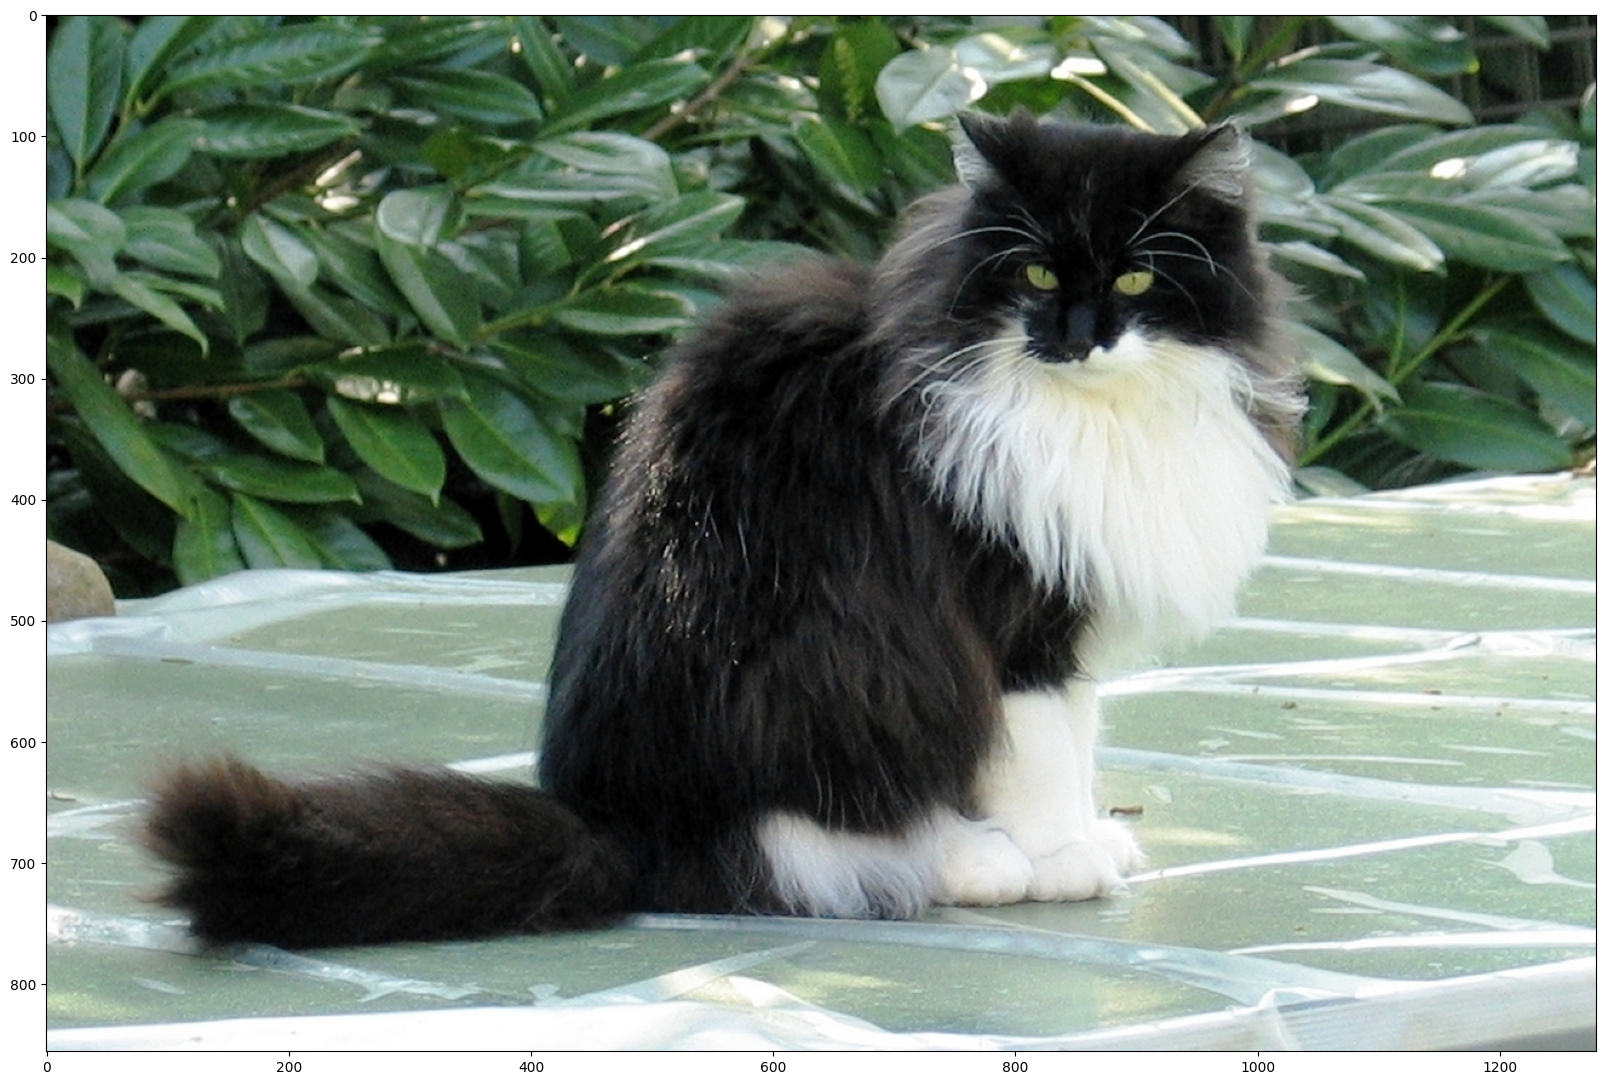

In [4]:
image_url ="https://upload.wikimedia.org/wikipedia/commons/a/a2/Cat_outside.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

## Pick a Model

1. Faster RCNN+Inception_Resnetv2:high accuracy,
2. SSD+ mobilenetv2: small and fast

In [5]:
module_handle = 'https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1'

In [6]:
detector = hub.load(module_handle).signatures['default']

In [7]:
def load_image(path):
  img =tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels =3)
  return img

In [8]:
def run_detector(detector,path):
  img = load_image(path)
  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key, value in result.items()}
  print('Found %d objects' % len(result['detection_scores']))
  print('Inference time: ', end_time - start_time)
  image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
  display_image(image_with_boxes)

Found 100 objects
Inference time:  1.2720389366149902


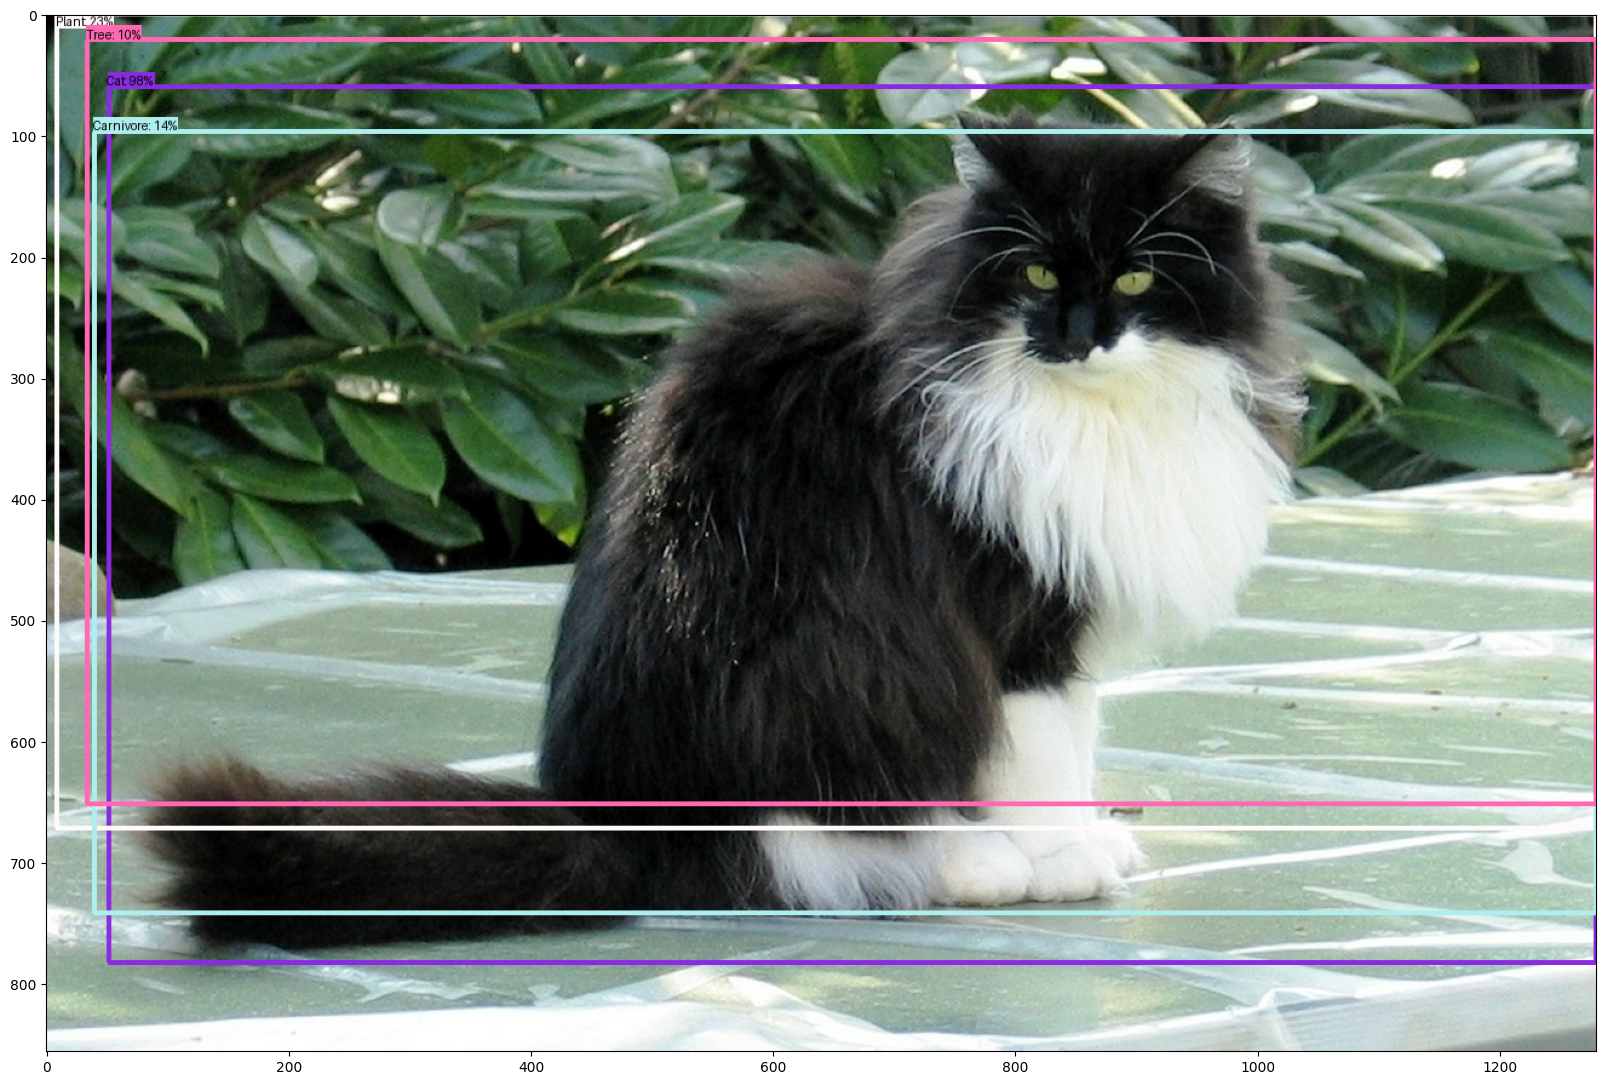

In [11]:
run_detector(detector, downloaded_image_path)